In [194]:
# Import drive and connect
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Check GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [677]:
# import main modules
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report, roc_curve, auc


In [28]:
# download and import packages for reading .tif files

!pip install pyrsgis
!pip install matplotlib_scalebar
from pyrsgis import raster
from pyrsgis.convert import changeDimension

In [836]:
# define functions for use in the notebook - these should be moved to a separate file but making that work with colab is turning out to be a real headache

def removeOuterEdges(x):
    '''Something is off with the top row in the satellite data, remove it.'''
    if x.ndim == 2: 
        x = np.delete(x, [0, x.shape[0]-1], axis=0) # remove top and bottom edges
        x = np.delete(x, [0, x.shape[1]-1], axis=1) # remove left and right edges
    else: 
        x = np.delete(x, [0, x.shape[1]-1], axis=1)
        x = np.delete(x, [0, x.shape[2]-1], axis=2)

    return x

def normalizeBand(band):
    '''normalize band inputs to 0-1 for input into neural nets'''
    band_min, band_max = band.min(), band.max()
    return ((band - band_min)/(band_max - band_min))

def normalizeUInt16Band(band):
    '''Bands 1-7 are uint16, ranging from 0-65535, normalize them by dividing by the max.'''
    return band/65535.



In [837]:
# define colormap for plots
discrete_cmap = mpl.colors.ListedColormap(["red", "cornflowerblue", "gold", "olivedrab"], name="discrete_cmap")
vmin=-1
vmax=2

In [838]:
# grab image file
training_image = "/content/drive/MyDrive/MangroveClassification/Images/Florida_1_2000.tif"

In [857]:
main_bands = [i+1 for i in range(0,7)]
# main_bands = [i+1 for i in range(1,7)]
ndvi_band = 9
labels_band = 8

# choose the input band(s)
# input_bands = ndvi_band
input_bands = main_bands

print('Analyzing bands: ', input_bands)

# read in band data
ds_features, features = raster.read(training_image, bands=input_bands) # if just inputting one band, do NOT put the single number in a list to pass to "bands", it causes some issue under the hood
ds_labels, labels = raster.read(training_image, bands=labels_band)

# remove outer edges of data (which sometimes have issues)
features = removeOuterEdges(features)
labels = removeOuterEdges(labels)

# fill NaNs with 0s
features = np.nan_to_num(features)
labels = np.nan_to_num(labels)

# store the number of bands, which will be useful for inputting to the neural network later
if features.ndim == 2: nBands = 1
else: nBands = features.shape[0]
print('nBands: ', nBands)

print('Feature shape: ', features.shape)


Analyzing bands:  [1, 2, 3, 4, 5, 6, 7]
nBands:  7
Feature shape:  (7, 445, 1855)


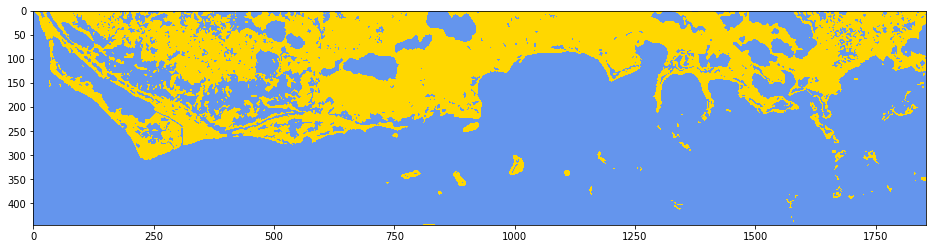

In [858]:
# plot NDVI band
if input_bands == ndvi_band:
  plt.figure(figsize=(16,6))
  plt.imshow(features, cmap='RdYlGn', vmin=-1, vmax=1)
  plt.colorbar()
  plt.show()

# plot label (mangrove) band
plt.figure(figsize=(16,6))
plt.imshow(labels, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
# plt.colorbar()
plt.show()

In [859]:
# change dimensions for input into neural net
features_input = changeDimension(features)
labels_input = changeDimension(labels)

print(features_input.shape)
print(labels_input.shape)

(825475, 7)
(825475,)


In [860]:
# convert labels to int for classification
labels_input = (labels_input == 1).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [861]:
# split the data
xTrain, xTest, yTrain, yTest = train_test_split(features_input, labels_input, test_size=0.4, random_state=42)

print(xTrain.shape)
print(yTrain.shape)

print(xTest.shape)
print(yTest.shape)

# reshape it as an additional step for input into the NN
xTrain = xTrain.reshape((xTrain.shape[0], 1, nBands))
xTest = xTest.reshape((xTest.shape[0], 1, nBands))

print(xTrain.shape)
print(xTest.shape)


(495285, 7)
(495285,)
(330190, 7)
(330190,)
(495285, 1, 7)
(330190, 1, 7)


In [862]:
# normalize bands - don't really need to do this for the NDVI band, and probably want to use something separate for the other bands, which are already by default bounded
# probably also do not want to normalize differently between the train and test, since their bounds are independent of the samples
# xTrain = normalizeBand(xTrain)
# xTest = normalizeBand(xTest)

# normalize main bands
if input_bands == main_bands:
  xTrain = normalizeUInt16Band(xTrain)
  xTest = normalizeUInt16Band(xTest)

In [863]:
# Define the parameters of the model
if input_bands == ndvi_band:
  model = keras.Sequential([
      keras.layers.Flatten(input_shape=(1, nBands)),
      # keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(10, activation='relu'),
      keras.layers.Dense(2, activation='softmax')])
else:
  model = keras.Sequential([
    keras.layers.Flatten(input_shape=(1, nBands)),
    # keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(14, activation='relu'),
    keras.layers.Dense(2, activation='softmax')])

# Define the accuracy metrics and parameters
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

print(model.summary)

<bound method Model.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff6df388190>>


In [864]:
# fit the model
history = model.fit(xTrain, yTrain, validation_split=0.3, epochs=3)

Epoch 1/3
10835/10835 [==============================] - 17s 2ms/step - loss: 0.2908 - accuracy: 0.8749 - val_loss: 0.1077 - val_accuracy: 0.9587
Epoch 2/3
10835/10835 [==============================] - 16s 2ms/step - loss: 0.1039 - accuracy: 0.9605 - val_loss: 0.1043 - val_accuracy: 0.9603
Epoch 3/3
10835/10835 [==============================] - 16s 2ms/step - loss: 0.1036 - accuracy: 0.9603 - val_loss: 0.1041 - val_accuracy: 0.9596


In [865]:
print(history.history)

# could make some plots of the metrics/conversion - would want to plot the f1 score though instead of accuracy
# fig, ax = plt.subplots()

# mae = history.history['mae']
# val_mae = history.history['val_mae']

# epochs = range(len(mae))

# ax.plot(epochs, mae, label='Train MAE')
# ax.plot(epochs, val_mae, label='Val MAE')

# ax.legend();

{'loss': [0.175160750746727, 0.10396948456764221, 0.10232659429311752], 'accuracy': [0.9315169453620911, 0.960279643535614, 0.9606517553329468], 'val_loss': [0.10765218734741211, 0.10428593307733536, 0.10406151413917542], 'val_accuracy': [0.9586502313613892, 0.9603394865989685, 0.9596126079559326]}


Confusion matrix:
 [[224872   7023]
 [  6218  92077]]

P-Score: 0.929, R-Score: 0.937
Accuracy: 0.960
f1: 0.933
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    231895
           1       0.93      0.94      0.93     98295

    accuracy                           0.96    330190
   macro avg       0.95      0.95      0.95    330190
weighted avg       0.96      0.96      0.96    330190



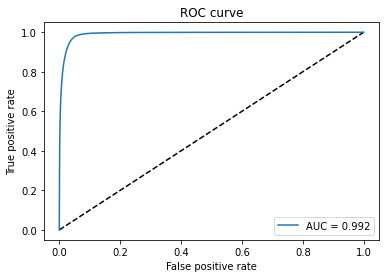

In [866]:
# Predict for test data 
yTest_pred_prob = model.predict(xTest)
yTest_pred_prob = yTest_pred_prob[:,1] # grab probablities for class label 1

# # Calculate and display the error metrics
yTest_pred = (yTest_pred_prob>0.5).astype(int) # convert prediction probabilities to 0 or 1 values depending on threshold
cMatrix = confusion_matrix(yTest, yTest_pred)
pScore = precision_score(yTest, yTest_pred)
rScore = recall_score(yTest, yTest_pred)
aScore = accuracy_score(yTest, yTest_pred)
f1Score = f1_score(yTest, yTest_pred)

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))
print('Accuracy: %.3f' % (aScore))
print('f1: %.3f' % (f1Score))

print(classification_report(yTest, yTest_pred))

# make roc_curve plot 
fpr_train, tpr_train, thresholds_train = roc_curve(yTest, yTest_pred_prob)
auc_train = auc(fpr_train, tpr_train)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_train, tpr_train, label='AUC = {:.3f}'.format(auc_train))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [867]:
# load up a new image to test on
test_image = "/content/drive/MyDrive/MangroveClassification/Images/Florida_3_2000.tif"

# read in band data
ds_features_test, features_test = raster.read(test_image, bands=input_bands)
ds_labels_test, labels_test = raster.read(test_image, bands=labels_band)

# remove outer edges of data (which sometimes have issues)
features_test = removeOuterEdges(features_test)
labels_test = removeOuterEdges(labels_test)

# fill NaNs with 0s
features_test = np.nan_to_num(features_test)
labels_test = np.nan_to_num(labels_test)

# change label from float to int
labels_test = (labels_test == 1).astype(int)

print('Check shapes:', features_test.shape, labels_test.shape)

Check shapes: (7, 445, 1854) (445, 1854)


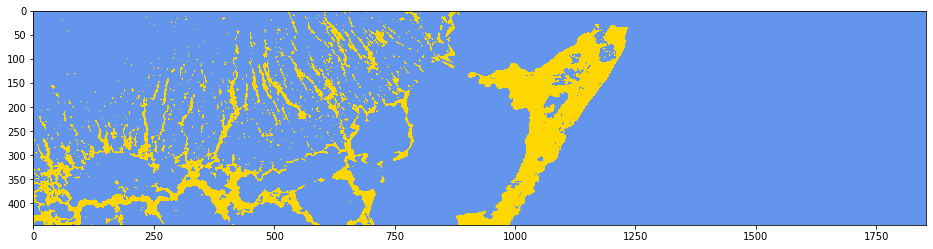

In [868]:
# plot NDVI band
if input_bands == ndvi_band:
  plt.figure(figsize=(16,6))
  plt.imshow(features_test, cmap='RdYlGn', vmin=-1, vmax=1)
  plt.colorbar()
  plt.show()

plt.figure(figsize=(16,6))
plt.imshow(labels_test, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
# plt.colorbar()
plt.show()

In [869]:
# change dimensions of input
features_test_input = changeDimension(features_test)
labels_test_input = changeDimension(labels_test)

# reshape it as an additional step for input into the NN
# features_test_input = features_test_input.reshape((features_test_input.shape[0], 1, features_test_input.shape[1]))
features_test_input = features_test_input.reshape((features_test_input.shape[0], 1, nBands))

print(features_test_input.shape)
print(labels_test_input.shape)

# normalize bands for test image
if input_bands == main_bands:
  features_test_input = normalizeUInt16Band(features_test_input)

(825030, 1, 7)
(825030,)


In [870]:
predicted_test_image_prob = model.predict(features_test_input)
predicted_test_image_prob = predicted_test_image_prob[:,1]

Confusion matrix:
 [[708461  19380]
 [ 17128  80061]]

P-Score: 0.805, R-Score: 0.824
Accuracy: 0.956
f1: 0.814
              precision    recall  f1-score   support

           0       0.98      0.97      0.97    727841
           1       0.81      0.82      0.81     97189

    accuracy                           0.96    825030
   macro avg       0.89      0.90      0.89    825030
weighted avg       0.96      0.96      0.96    825030



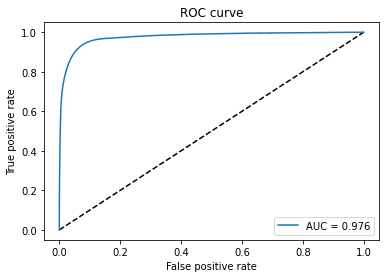

In [871]:
# convert to 1 or 0 if above threshold
predicted_test_image_aboveThresh = (predicted_test_image_prob>0.5).astype(int)

cMatrix = confusion_matrix(labels_test_input, predicted_test_image_aboveThresh)
pScore = precision_score(labels_test_input, predicted_test_image_aboveThresh)
rScore = recall_score(labels_test_input, predicted_test_image_aboveThresh)
aScore = accuracy_score(labels_test_input, predicted_test_image_aboveThresh)
f1Score = f1_score(labels_test_input, predicted_test_image_aboveThresh)

print("Confusion matrix:\n", cMatrix)
print("\nP-Score: %.3f, R-Score: %.3f" % (pScore, rScore))
print('Accuracy: %.3f' % (aScore))
print('f1: %.3f' % (f1Score))

print(classification_report(labels_test_input, predicted_test_image_aboveThresh))

# make roc_curve plot 
fpr_test, tpr_test, thresholds_test = roc_curve(labels_test_input, predicted_test_image_prob)
auc_test = auc(fpr_test, tpr_test)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_test, tpr_test, label='AUC = {:.3f}'.format(auc_test))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [872]:
prediction_test_image_2d = np.reshape(predicted_test_image_aboveThresh, (ds_labels_test.RasterYSize-2, ds_labels_test.RasterXSize-2)) # need the -2s since I removed the outer edges

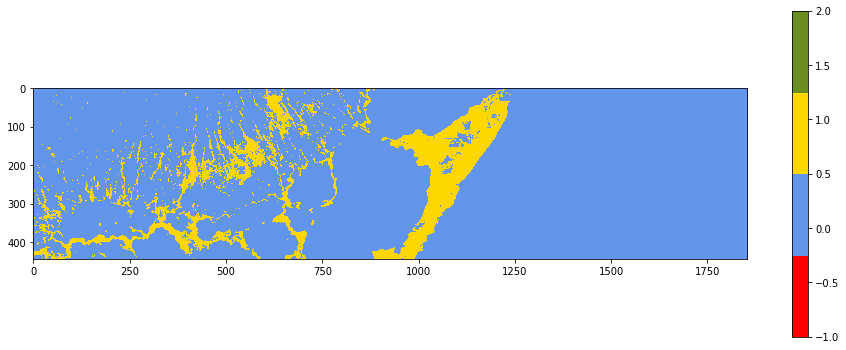

In [873]:
plt.figure(figsize=(16,6))
plt.imshow(prediction_test_image_2d, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()

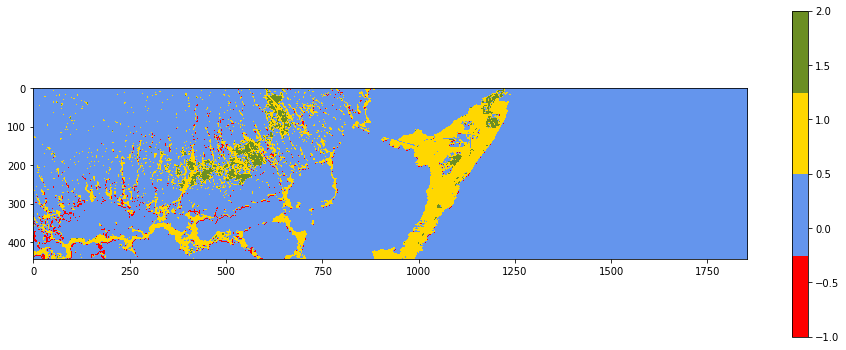

In [874]:
# multiple first array by 2 in order to get 4 values for difference plot:
# pred - label -> output
# 0 - 0 -> 0, predicted and label/past are not mangroves
# 1 - 1 -> 1, predicted and label/past are mangroves
# 1 - 0 -> 2, predicted was mangrove, label/past was not -> growth/false positive
# 0 - 1 -> 0, predicted was not mangrove, label/past was -> loss/false negative
image_difference = 2 * prediction_test_image_2d - labels_test
plt.figure(figsize=(16,6))
plt.imshow(image_difference, cmap=discrete_cmap, vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()